# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
from os.path import isfile, join
import time

Решил загрузить так же, как показано в семинаре. Создал свой дропбокс и туда закинул zip

In [ ]:
!wget https://www.dropbox.com/s/iepwthelje6rzaj/dataset.zip
!unzip -q dataset.zip

--2020-12-25 10:19:03--  https://www.dropbox.com/s/iepwthelje6rzaj/dataset.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/iepwthelje6rzaj/dataset.zip [following]
--2020-12-25 10:19:03--  https://www.dropbox.com/s/raw/iepwthelje6rzaj/dataset.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc02704ccbfc2f15d06fdeb72715.dl.dropboxusercontent.com/cd/0/inline/BFvqlgROsW1HWY-HHy5YSik9-SJ04bydtFQlQStXng7G9xTUZMmXwNCUcwFZHbGFQnQpuQDK0QHNwE6GzDQeVtTrtjerYkJtIYL2dU7lKUeK2qQIMaoN_GDsKDdBGx64GG0/file# [following]
--2020-12-25 10:19:04--  https://uc02704ccbfc2f15d06fdeb72715.dl.dropboxusercontent.com/cd/0/inline/BFvqlgROsW1HWY-HHy5YSik9-SJ04bydtFQlQStXng7G9xTUZMmXwNCUcwFZHbGFQnQpuQDK0QHNwE6GzDQeVtTrtjerYkJtIYL2dU7lKUeK2qQIMa

Вместо написания класса использовал готовые функции torchvision.datasets.ImageFolder и torch.utils.data.DataLoader.

In [ ]:
batch_size = 32

Создадим даталоадеры для обоих сетов и добавим аугментации

In [ ]:
train_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),])
val_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(),])

train_dataset = torchvision.datasets.ImageFolder(root=("./dataset/dataset/train"), transform = train_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataset = torchvision.datasets.ImageFolder(root=("./dataset/dataset/val"), transform=val_transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


1) Переводим модель, изображения и классы на device; 2) Зануляем градиенты; 3) Прогоняем модель; 4) Считаем ошибку; 5) Считаем градиент по ошибке; 6) Шаг градиентного спуска



In [ ]:
import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.to(device) 
    model.train()
    for pict, lab in train_dataloader:
      pict = pict.to(device)
      lab = lab.to(device)
      optimizer.zero_grad()
      predictions = model(pict)
      funct = criterion(predictions, lab)
      loss = funct
      loss.backward()
      optimizer.step()
    pass

1) Создаём списки и нампай-массивы для ошибок, предсказаний и настоящих классов; 2) В цикле переводим изображения из валидации и классы на device; 3) Прогоняем модель; 4) Считаем и возвращаем среднюю ошибку, и среднюю accuracy (итоговый losses - это список из собственно losses и accuracy); 5) Возвращаем предсказанные классы и истинные классы

In [ ]:
def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.eval()
    losses = []                                                        
    predicted_classes = np.array([])
    true_classes = np.array([])

    for pict, lab in val_dataloader: 
      pict = pict.to(device)
      lab = lab.to(device) 
      y_forecasted = model(pict)
      crit = criterion(y_forecasted, lab)
      x = crit.item()
      losses.append(x)
      y_forecasted = y_forecasted.argmax(1).cpu().detach().numpy()
      lab1 = lab.cpu().detach().numpy()
      predicted_classes = np.append(predicted_classes, y_forecasted)
      true_classes = np.append(true_classes, lab1)

    losses = np.mean(np.array(losses))
    val_accur = (predicted_classes == true_classes).mean()
    losses = [losses, val_accur]

    return losses, predicted_classes, true_classes
    pass

Для каждой эпохи выводим индекс эпохи и выполняем уже написанную функцию train, выполняем функцию predict для валидации, записываем время выполнения, accuracy и ошибку

In [ ]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)

    for i in range(n_epochs):
        print("epoch {}/{}..".format(i, n_epochs))
        start = time.time()
        train_one_epoch(model, train_dataloader, criterion, optimizer)
        end = time.time()
        losses, predicted_classes, true_classes = predict(model, val_dataloader, criterion)
        t = end - start
        accur = losses[1]
        loss = losses[0]
        print("epoch {} accomplished in {} seconds".format(i, round(t, 3)))
        print("accuracy after epoch {} is {}:".format(i, round(accur, 3)))
        print("loss after epoch {} is {}:".format(i, round(loss, 3)))
        print()
        pass

Возьмем предообученный resnet18 и обучим только последний полносвязный слой

In [ ]:
from torchvision.models import resnet18 

In [ ]:
model0 = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Посмотрим сколько входов на полносвзяном слое, чтобы обучить свой

In [ ]:
?model0

Значит, на нашем полносвязном слое должно быть 512 входов

Критерий лосса - кросс-энтропия, оптимизатор - Adam, lr=3e-4

In [ ]:
model = resnet18(pretrained=True)
for var in model.parameters():
    var.requires_grad = False
model.fc = nn.Linear(512, 200)

optimizer = torch.optim.Adam(model.fc.parameters(), 3e-4) 
train_dataloader = train_dataloader 
val_dataloader = val_dataloader
criterion = nn.CrossEntropyLoss()
scheduler = None
n_epochs = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Запустим обучение 

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

epoch 0/10..
epoch 0 accomplished in 79.201 seconds
accuracy after epoch 0 is 0.53:
loss after epoch 0 is 1.984:

epoch 1/10..
epoch 1 accomplished in 78.436 seconds
accuracy after epoch 1 is 0.546:
loss after epoch 1 is 1.871:

epoch 2/10..
epoch 2 accomplished in 77.858 seconds
accuracy after epoch 2 is 0.56:
loss after epoch 2 is 1.834:

epoch 3/10..
epoch 3 accomplished in 78.67 seconds
accuracy after epoch 3 is 0.566:
loss after epoch 3 is 1.819:

epoch 4/10..
epoch 4 accomplished in 79.934 seconds
accuracy after epoch 4 is 0.562:
loss after epoch 4 is 1.832:

epoch 5/10..
epoch 5 accomplished in 79.198 seconds
accuracy after epoch 5 is 0.558:
loss after epoch 5 is 1.848:

epoch 6/10..
epoch 6 accomplished in 78.448 seconds
accuracy after epoch 6 is 0.566:
loss after epoch 6 is 1.831:

epoch 7/10..
epoch 7 accomplished in 79.451 seconds
accuracy after epoch 7 is 0.561:
loss after epoch 7 is 1.838:

epoch 8/10..
epoch 8 accomplished in 80.063 seconds
accuracy after epoch 8 is 0.566

Простой тест на проверку правильности написанного кода

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

tests passed


После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))

Оценка за это задание составит 5 баллов


## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
# we will need this library to process the labeling
! pip install xmltodict

In [ ]:
import xmltodict, json

In [ ]:
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc

Загрузим Датасет так же как в первой задаче через дропбокс

In [ ]:
!wget https://www.dropbox.com/s/h04x6z6afoi8ymo/archive.zip
!unzip -q archive.zip

--2020-11-30 21:15:10--  https://www.dropbox.com/s/h04x6z6afoi8ymo/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/h04x6z6afoi8ymo/archive.zip [following]
--2020-11-30 21:15:11--  https://www.dropbox.com/s/raw/h04x6z6afoi8ymo/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc77704b1152f2d60068de723fd3.dl.dropboxusercontent.com/cd/0/inline/BENYdR9C1LdYSLG6Ay3bEukUBPp-nxmgpHfe6vLeaotTRN4h6lfz4Uaxgl0z-3Cv1WzH1XDBH6ydoePc9d8dXb3SMKnCUBUG0TdGS9SQK8N4XCNpr6buyk4kunkBp95zcuY/file# [following]
--2020-11-30 21:15:11--  https://uc77704b1152f2d60068de723fd3.dl.dropboxusercontent.com/cd/0/inline/BENYdR9C1LdYSLG6Ay3bEukUBPp-nxmgpHfe6vLeaotTRN4h6lfz4Uaxgl0z-3Cv1WzH1XDBH6ydoePc9d8dXb3SMKnCUBUG0TdGS9SQK8N4XCNpr6buy

Напишем датасет

In [ ]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Техническая работа

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """
    dt = dt_bbox
    gt = gt_bbox
    maxX = max(dt[0], gt[0])
    minX = min(dt[2], gt[2])
    maxY = max(dt[1], gt[1])
    minY = min(dt[3], gt[3])
    if minX < maxX or minY < maxY:
        return 0
    else:
        inter = (minX - maxX) * (minY - maxY)
    union = (dt[2] - dt[0]) * (dt[3] - dt[1]) + (gt[2] - gt[0]) * (gt[3] - gt[1]) - inter

    return float(inter) / union

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    # правильные прямоугольники
    gt_bboxes = target_true['boxes'].numpy()
    gt_labels = target_true['labels'].numpy()

    # предсказания модели
    dt_bboxes = target_pred['boxes'].numpy()
    dt_labels = target_pred['labels'].numpy()
    dt_scores = target_pred['scores'].numpy()

    results = []
    # для каждого прямоугольника из предсказания находим максимально близкий прямоугольник среди ответов
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {'score': dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        
        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            # для прямоугольника detection_id нашли правильный ответ, который имеет IoU больше 0.5 
            detection_result_dict['TP'] = 1
            # удаляем эти прямоугольники из данных, чтобы больше не матчить с ними
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict['TP'] = 0

        results.append(detection_result_dict)

    # возвращаем результат, для кажого прямоугольника говорим, смогли ли сматчить его с чем то из ответов
    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)

            targets_true = [{k: v.cpu().float() for k, v in t.items()} for t in targets_true]
            targets_pred = [{k: v.cpu().float() for k, v in t.items()} for t in targets_pred]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true['labels'].shape[0]

                # матчим ответы с правильными боксами
                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k['score'], reverse=True)

    # считаем точность и полноту, чтобы потом посчитать mAP как auc
    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]['TP'] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]['TP'] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]['TP']) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

Установим библиотеку albumentations

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

     |████████████████████████████████| 81kB 5.6MB/s 
     |████████████████████████████████| 952kB 13.0MB/s 
     |████████████████████████████████| 36.7MB 91kB/s 
albumentations==0.5.2 is successfully installed


In [ ]:
%matplotlib inline

In [ ]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

In [ ]:
from albumentations.pytorch.transforms import ToTensor

Функция train_one_epoch 

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    n = 0
    totalLoss = 0
    for pictures, lab in data_loader:
        pictures = list(image.to(device).float() for image in pictures)
        lab = [{k: v.to(device) for k, v in t.items()} for t in lab]

        loss_dct = model(pictures, lab)
        losses = sum(loss for loss in loss_dct.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        x = losses.cpu().detach().numpy()
        totalLoss += float(x)

        if n % 10 == 0:
            print("Loss value after {} batches is {}".format(n, round(totalLoss / n, 3)))

    return totalLoss


def train(model, n_epochs, train_dataloader, val_dataloader, optimizer, device):
    for epoch in range(n_epochs):
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        print("AUC ON TEST: {}".format(a))
        model.train()
        train_one_epoch(model, optimizer, train_dataloader, device=device)

Воспользуемся функцией collate

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
A.Compose?

Добавим аугментации

In [ ]:
train_transform = A.Compose([ 
                              A.VerticalFlip(p=0.5),
                              A.HorizontalFlip(p=0.5),
                              A.RandomBrightnessContrast(p=0.3),
                              A.pytorch.ToTensor()
                                      ], 
                            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']),)
val_transform = A.Compose([A.pytorch.ToTensor()
                                      ])

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn

Используем предобученную модель Faster RCNN

In [ ]:
def get_detection_model(num_classes=2):
    model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

Имеем 4 класса, так есть ещё фон

В качестве оптимайзера возьмем SGD momentum

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
num_epochs = 8
num_classes = 4
model = get_detection_model(num_classes)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


Запустим обучение

In [ ]:
train(model, num_epochs, train_dataloader, val_dataloader, optimizer, device)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.0029185548597543643
Loss value after 10 batches is 0.817
Loss value after 20 batches is 0.579
Loss value after 30 batches is 0.521
Loss value after 40 batches is 0.47
Loss value after 50 batches is 0.427
Loss value after 60 batches is 0.411
Loss value after 70 batches is 0.391
Loss value after 80 batches is 0.375
Loss value after 90 batches is 0.361
Loss value after 100 batches is 0.346
Loss value after 110 batches is 0.338
Loss value after 120 batches is 0.332


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.7074202671859102
Loss value after 10 batches is 0.307
Loss value after 20 batches is 0.26
Loss value after 30 batches is 0.22
Loss value after 40 batches is 0.225
Loss value after 50 batches is 0.217
Loss value after 60 batches is 0.222
Loss value after 70 batches is 0.212
Loss value after 80 batches is 0.214
Loss value after 90 batches is 0.211
Loss value after 100 batches is 0.214
Loss value after 110 batches is 0.213
Loss value after 120 batches is 0.208


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.8781183556267351
Loss value after 10 batches is 0.201
Loss value after 20 batches is 0.214
Loss value after 30 batches is 0.221
Loss value after 40 batches is 0.215
Loss value after 50 batches is 0.193
Loss value after 60 batches is 0.191
Loss value after 70 batches is 0.188
Loss value after 80 batches is 0.186
Loss value after 90 batches is 0.187
Loss value after 100 batches is 0.182
Loss value after 110 batches is 0.179
Loss value after 120 batches is 0.179


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.8901052832842615
Loss value after 10 batches is 0.124
Loss value after 20 batches is 0.146
Loss value after 30 batches is 0.155
Loss value after 40 batches is 0.163
Loss value after 50 batches is 0.157
Loss value after 60 batches is 0.149
Loss value after 70 batches is 0.147
Loss value after 80 batches is 0.147
Loss value after 90 batches is 0.156
Loss value after 100 batches is 0.154
Loss value after 110 batches is 0.16
Loss value after 120 batches is 0.16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9123165773742877
Loss value after 10 batches is 0.197
Loss value after 20 batches is 0.194
Loss value after 30 batches is 0.187
Loss value after 40 batches is 0.169
Loss value after 50 batches is 0.162
Loss value after 60 batches is 0.157
Loss value after 70 batches is 0.155
Loss value after 80 batches is 0.163
Loss value after 90 batches is 0.159
Loss value after 100 batches is 0.159
Loss value after 110 batches is 0.158
Loss value after 120 batches is 0.155


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9053899210403812
Loss value after 10 batches is 0.115
Loss value after 20 batches is 0.111
Loss value after 30 batches is 0.114
Loss value after 40 batches is 0.109
Loss value after 50 batches is 0.119
Loss value after 60 batches is 0.122
Loss value after 70 batches is 0.128
Loss value after 80 batches is 0.134
Loss value after 90 batches is 0.137
Loss value after 100 batches is 0.138
Loss value after 110 batches is 0.139
Loss value after 120 batches is 0.136


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9294767378810944
Loss value after 10 batches is 0.132
Loss value after 20 batches is 0.148
Loss value after 30 batches is 0.133
Loss value after 40 batches is 0.14
Loss value after 50 batches is 0.136
Loss value after 60 batches is 0.137
Loss value after 70 batches is 0.134
Loss value after 80 batches is 0.131
Loss value after 90 batches is 0.132
Loss value after 100 batches is 0.128
Loss value after 110 batches is 0.131
Loss value after 120 batches is 0.133


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

AUC ON TEST: 0.9116630784398949
Loss value after 10 batches is 0.105
Loss value after 20 batches is 0.111
Loss value after 30 batches is 0.115
Loss value after 40 batches is 0.112
Loss value after 50 batches is 0.119
Loss value after 60 batches is 0.121
Loss value after 70 batches is 0.123
Loss value after 80 batches is 0.123
Loss value after 90 batches is 0.125
Loss value after 100 batches is 0.126
Loss value after 110 batches is 0.129
Loss value after 120 batches is 0.129


__Выведите итоговое качество модели__.

In [ ]:
auc = evaluate(model, val_dataloader, device)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Оценка за это задание составит 3.9684192125714883 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [ ]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

In [ ]:
from torchvision import transforms

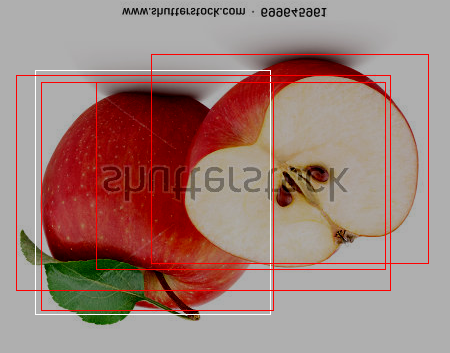

In [ ]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image